In [32]:
import requests
# settings.py
API_KEY = 'CI5Ekn6MBnN8s2q7VLFushZXx'
API_SECRET_KEY = '2lRITnWOAFOV3qhksjAcxbI3iCGxC7rE1OTtAPTiVsuWtdkEk8'
ACCESS_TOKEN = '1646245338045349888-AnjUoA8yoQ5iThY57LZW0mrsVufQ7P'
ACCESS_TOKEN_SECRET = 'do5rfXGPT5OaMJcoZwDVcfbTQRlqZPDgnq64vlIw8c0lO'
BEARER_TOKEN = 'AAAAAAAAAAAAAAAAAAAAAJEioAEAAAAAfdcUcfrG9UU6i5C8cyunJjvtz44%3DDamiep88WsI58HONgQzU3BQ9asUdvwhtsKBruWdY5QFn7ZtWcc'

### tried methods (but failed ones) : 1.  OAuth1(client ids and client secrets) 2. API keys and secrets
### tried best method: beare token 

In [38]:
import requests

# Construct the API request URL
base_url = "https://api.twitter.com/2/tweets/search/recent"

params = {
    'query': 'metaverse',
    "tweet.fields": "created_at",
    #'tweet_mode': 'extended',
    #'lang': 'en',
    "max_results": 100,  # Maximum number of tweets per request
    #'count': '500'
}


#'start_date': datetime(2023, 5, 25)


response = requests.get(base_url,
    params=params,
    headers = {"Authorization": f"Bearer {BEARER_TOKEN}"}
)



if response.status_code == 200:
    # Retrieve the tweets from the response
    json_response = response.json()
    tweets = json_response.get("data", [])

    # Iterate over the retrieved tweets
    for tweet in tweets:
        created_at = tweet.get("created_at")
        tweet_text = tweet.get("text")
        print(f"{created_at}: {tweet_text}")
        # Perform further processing or analysis on each tweet as needed

else:
    print(f"Error: {response.status_code} - {response.text}")

2023-06-09T20:52:51.000Z: @whale_alert @CryptoNewton Who want to reach big potential. Reliable team, big project and believer joiners. Let's grow together. 

#BTC #Crypto #altcoin #ETH #metaverse #al #gaming #NFT #defi #web3 #PlayToEarn #DOGE #SHIB #Elon #Floki #gem #100x #PepeCoin #pepe

@GalioToken
2023-06-09T20:52:50.000Z: RT @CEEK: Ready to #CEEK #ANEWREALITY
 @apple #Visionpro joins #Metaverse 
CEEK has been paving the way for this EPIC moment in #VR #Web3…
2023-06-09T20:52:48.000Z: @SharksCoins 新的大型游戏项目来了。 这是伽利略。 拥有庞大支持者群体的伽利略将大放异彩。 让我们一起赢。
#BTC #Crypto #altcoin #ETH #metaverse #al #gaming #NFT #defi #web3 #PlayToEarn  #DOGE #SHIB #Elon #Floki #kucoin #gem #100x #PepeCoin #pepe

@GalioToken
2023-06-09T20:52:48.000Z: RT @edz_lozano: $100 IN 24 HRS

$50
- Follow: https://t.co/yKvfwBBWH2

$50
- Join https://t.co/BDZ071UXcr

_________________

Bringing Next…
2023-06-09T20:52:48.000Z: RT @ENSpunks: As a thank you to the @ENSMaxisNFT community I am cooking up something special for the 

In [39]:
tweets

[{'text': "@whale_alert @CryptoNewton Who want to reach big potential. Reliable team, big project and believer joiners. Let's grow together. \n\n#BTC #Crypto #altcoin #ETH #metaverse #al #gaming #NFT #defi #web3 #PlayToEarn #DOGE #SHIB #Elon #Floki #gem #100x #PepeCoin #pepe\n\n@GalioToken",
  'id': '1667273576385224705',
  'edit_history_tweet_ids': ['1667273576385224705'],
  'created_at': '2023-06-09T20:52:51.000Z'},
 {'text': 'RT @CEEK: Ready to #CEEK #ANEWREALITY\n @apple #Visionpro joins #Metaverse \nCEEK has been paving the way for this EPIC moment in #VR #Web3…',
  'id': '1667273569561108480',
  'edit_history_tweet_ids': ['1667273569561108480'],
  'created_at': '2023-06-09T20:52:50.000Z'},
 {'text': '@SharksCoins 新的大型游戏项目来了。 这是伽利略。 拥有庞大支持者群体的伽利略将大放异彩。 让我们一起赢。\n#BTC #Crypto #altcoin #ETH #metaverse #al #gaming #NFT #defi #web3 #PlayToEarn  #DOGE #SHIB #Elon #Floki #kucoin #gem #100x #PepeCoin #pepe\n\n@GalioToken',
  'id': '1667273564666429443',
  'edit_history_tweet_ids': ['16672

In [40]:
def get_data(tweet):
    data = {
        'id': tweet['id'],
        'created_at': tweet['created_at'],
        'text': tweet['text']
    }
    return data

In [41]:
import pandas as pd


df1 = pd.DataFrame()
for tweet in tweets:
    row = get_data(tweet)
    df1 = df1.append(row, ignore_index=True)

In [42]:
df1.to_csv('tweets.csv', index=False)

## read csv and load in 

In [2]:
import pandas as pd
import os

In [15]:
parent_dir = os.path.dirname(os.getcwd())
tweets_path = os.path.join(parent_dir, "data", "raw", "tweets_raw.csv")

dfxf= pd.read_csv(tweets_path)
dfxf


,id,created_at,text
0,1667014913640878081,2023-06-09T03:45:01.000Z,RT @Spears_ETH98: LISTEN UP WEB3. 👹\n\nTHE $LO...
1,1667014913322041346,2023-06-09T03:45:01.000Z,RT @Spears_ETH98: LISTEN UP WEB3. 👹\n\nTHE $LO...
2,1667014911933960193,2023-06-09T03:45:01.000Z,RT @OfficialXFS: 📣 We want to give a warm welc...
3,1667014910759301122,2023-06-09T03:45:01.000Z,RT @Spears_ETH98: LISTEN UP WEB3. 👹\n\nTHE $LO...
4,1667014910272843777,2023-06-09T03:45:00.000Z,RT @Spears_ETH98: LISTEN UP WEB3. 👹\n\nTHE $LO...
...,...,...,...
95,1667014858947043330,2023-06-09T03:44:48.000Z,RT @Spears_ETH98: LISTEN UP WEB3. 👹\n\nTHE $LO...
96,1667014857248440322,2023-06-09T03:44:48.000Z,RT @Spears_ETH98: LISTEN UP WEB3. 👹\n\nTHE $LO...
97,1667014856736931840,2023-06-09T03:44:48.000Z,RT @Spears_ETH98: LISTEN UP WEB3. 👹\n\nTHE $LO...
98,1667014856711495681,2023-06-09T03:44:48.000Z,RT @Spears_ETH98: LISTEN UP WEB3. 👹\n\nTHE $LO...


In [16]:
##data cleaning 

# Using regular expressions (RegEx) through the re module
import re
whitespace = re.compile(r"\s+")
web_address = re.compile(r"(?i)http(s):\/\/[a-z0-9.~_\-\/]+")
tesla = re.compile(r"(?i)@Tesla(?=\b)")
user = re.compile(r"(?i)@[a-z0-9_]+")

# Go through each tweet and clean 
lsx = list(dfxf.iloc[:,2])
dfxf["cleaned_text"] = 0
for i in range(0, len(dfxf)):
    tweet = lsx[i]
    # we then use the sub method to replace anything matching
    tweet = whitespace.sub(' ', tweet)
    tweet = web_address.sub('', tweet)
    #tweet = metaverse.sub('metaverse', tweet)
    tweet = user.sub('', tweet)
    dfxf["cleaned_text"][i] = tweet
dfxf

C:\Users\HP\AppData\Local\Temp\ipykernel_24992\2028882687.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfxf["cleaned_text"][i] = tweet


,id,created_at,text,cleaned_text
0,1667014913640878081,2023-06-09T03:45:01.000Z,RT @Spears_ETH98: LISTEN UP WEB3. 👹\n\nTHE $LO...,RT : LISTEN UP WEB3. 👹 THE $LOYAL AIRDROP IS N...
1,1667014913322041346,2023-06-09T03:45:01.000Z,RT @Spears_ETH98: LISTEN UP WEB3. 👹\n\nTHE $LO...,RT : LISTEN UP WEB3. 👹 THE $LOYAL AIRDROP IS N...
2,1667014911933960193,2023-06-09T03:45:01.000Z,RT @OfficialXFS: 📣 We want to give a warm welc...,RT : 📣 We want to give a warm welcome to who ...
3,1667014910759301122,2023-06-09T03:45:01.000Z,RT @Spears_ETH98: LISTEN UP WEB3. 👹\n\nTHE $LO...,RT : LISTEN UP WEB3. 👹 THE $LOYAL AIRDROP IS N...
4,1667014910272843777,2023-06-09T03:45:00.000Z,RT @Spears_ETH98: LISTEN UP WEB3. 👹\n\nTHE $LO...,RT : LISTEN UP WEB3. 👹 THE $LOYAL AIRDROP IS N...
...,...,...,...,...
95,1667014858947043330,2023-06-09T03:44:48.000Z,RT @Spears_ETH98: LISTEN UP WEB3. 👹\n\nTHE $LO...,RT : LISTEN UP WEB3. 👹 THE $LOYAL AIRDROP IS N...
96,1667014857248440322,2023-06-09T03:44:48.000Z,RT @Spears_ETH98: LISTEN UP WEB3. 👹\n\nTHE $LO...,RT : LISTEN UP WEB3. 👹 THE $LOYAL AIRDROP IS N...
97,1667014856736931840,2023-06-09T03:44:48.000Z,RT @Spears_ETH98: LISTEN UP WEB3. 👹\n\nTHE $LO...,RT : LISTEN UP WEB3. 👹 THE $LOYAL AIRDROP IS N...
98,1667014856711495681,2023-06-09T03:44:48.000Z,RT @Spears_ETH98: LISTEN UP WEB3. 👹\n\nTHE $LO...,RT : LISTEN UP WEB3. 👹 THE $LOYAL AIRDROP IS N...


In [17]:
#labelling each tweet with emotions label 
import flair
sentiment_model = flair.models.TextClassifier.load('en-sentiment')

# #example of labelliing 
# TEXT = "Metaverse is hopeful "
# TEXT_neg = "Metaverse is hopeless"

# print("Example of a positive sentiment sentence")
# sentence1 = flair.data.Sentence(TEXT)
# sentiment_model.predict(sentence1)
# print(sentence1)

# print("Example of a negative sentiment sentence")
# sentence2 = flair.data.Sentence(TEXT_neg)
# sentiment_model.predict(sentence2)
# print(sentence2)

In [18]:
## add sentimeent to each sentence
probs= []
sentiments = []
score = []
for i in range(0, len(dfxf)):
    tweet  = dfxf.iloc[i,3]
    sentence = flair.data.Sentence(tweet)
    sentiment_model.predict(sentence)
    # extract sentiment prediction
    probs.append(sentence.labels[0].score)  # numerical score 0-1
    sentiments.append(sentence.labels[0].value)  # 'POSITIVE' or 'NEGATIVE'
    if sentence.labels[0].value == "NEGATIVE":
        score.append(-sentence.labels[0].score) 
    else: 
        score.append(sentence.labels[0].score) 
# add probability and sentiment predictions to df0
dfxf['probability'] = probs
dfxf['sentiment'] = sentiments
dfxf['score'] = score
dfxf

,id,created_at,text,cleaned_text,probability,sentiment,score
0,1667014913640878081,2023-06-09T03:45:01.000Z,RT @Spears_ETH98: LISTEN UP WEB3. 👹\n\nTHE $LO...,RT : LISTEN UP WEB3. 👹 THE $LOYAL AIRDROP IS N...,0.999915,NEGATIVE,-0.999915
1,1667014913322041346,2023-06-09T03:45:01.000Z,RT @Spears_ETH98: LISTEN UP WEB3. 👹\n\nTHE $LO...,RT : LISTEN UP WEB3. 👹 THE $LOYAL AIRDROP IS N...,0.999915,NEGATIVE,-0.999915
2,1667014911933960193,2023-06-09T03:45:01.000Z,RT @OfficialXFS: 📣 We want to give a warm welc...,RT : 📣 We want to give a warm welcome to who ...,0.979678,POSITIVE,0.979678
3,1667014910759301122,2023-06-09T03:45:01.000Z,RT @Spears_ETH98: LISTEN UP WEB3. 👹\n\nTHE $LO...,RT : LISTEN UP WEB3. 👹 THE $LOYAL AIRDROP IS N...,0.999915,NEGATIVE,-0.999915
4,1667014910272843777,2023-06-09T03:45:00.000Z,RT @Spears_ETH98: LISTEN UP WEB3. 👹\n\nTHE $LO...,RT : LISTEN UP WEB3. 👹 THE $LOYAL AIRDROP IS N...,0.999915,NEGATIVE,-0.999915
...,...,...,...,...,...,...,...
95,1667014858947043330,2023-06-09T03:44:48.000Z,RT @Spears_ETH98: LISTEN UP WEB3. 👹\n\nTHE $LO...,RT : LISTEN UP WEB3. 👹 THE $LOYAL AIRDROP IS N...,0.999915,NEGATIVE,-0.999915
96,1667014857248440322,2023-06-09T03:44:48.000Z,RT @Spears_ETH98: LISTEN UP WEB3. 👹\n\nTHE $LO...,RT : LISTEN UP WEB3. 👹 THE $LOYAL AIRDROP IS N...,0.999915,NEGATIVE,-0.999915
97,1667014856736931840,2023-06-09T03:44:48.000Z,RT @Spears_ETH98: LISTEN UP WEB3. 👹\n\nTHE $LO...,RT : LISTEN UP WEB3. 👹 THE $LOYAL AIRDROP IS N...,0.999915,NEGATIVE,-0.999915
98,1667014856711495681,2023-06-09T03:44:48.000Z,RT @Spears_ETH98: LISTEN UP WEB3. 👹\n\nTHE $LO...,RT : LISTEN UP WEB3. 👹 THE $LOYAL AIRDROP IS N...,0.999915,NEGATIVE,-0.999915


In [21]:
dfxf = dfxf.sort_values(by = 'created_at')
dfxf

,id,created_at,text,cleaned_text,probability,sentiment,score
99,1667014856304648193,2023-06-09T03:44:48.000Z,RT @Spears_ETH98: LISTEN UP WEB3. 👹\n\nTHE $LO...,RT : LISTEN UP WEB3. 👹 THE $LOYAL AIRDROP IS N...,0.999915,NEGATIVE,-0.999915
90,1667014860314406913,2023-06-09T03:44:48.000Z,RT @Spears_ETH98: LISTEN UP WEB3. 👹\n\nTHE $LO...,RT : LISTEN UP WEB3. 👹 THE $LOYAL AIRDROP IS N...,0.999915,NEGATIVE,-0.999915
91,1667014860209631232,2023-06-09T03:44:48.000Z,RT @Spears_ETH98: LISTEN UP WEB3. 👹\n\nTHE $LO...,RT : LISTEN UP WEB3. 👹 THE $LOYAL AIRDROP IS N...,0.999915,NEGATIVE,-0.999915
92,1667014859857305602,2023-06-09T03:44:48.000Z,RT @Spears_ETH98: LISTEN UP WEB3. 👹\n\nTHE $LO...,RT : LISTEN UP WEB3. 👹 THE $LOYAL AIRDROP IS N...,0.999915,NEGATIVE,-0.999915
93,1667014859853012997,2023-06-09T03:44:48.000Z,RT @Spears_ETH98: LISTEN UP WEB3. 👹\n\nTHE $LO...,RT : LISTEN UP WEB3. 👹 THE $LOYAL AIRDROP IS N...,0.999915,NEGATIVE,-0.999915
...,...,...,...,...,...,...,...
4,1667014910272843777,2023-06-09T03:45:00.000Z,RT @Spears_ETH98: LISTEN UP WEB3. 👹\n\nTHE $LO...,RT : LISTEN UP WEB3. 👹 THE $LOYAL AIRDROP IS N...,0.999915,NEGATIVE,-0.999915
1,1667014913322041346,2023-06-09T03:45:01.000Z,RT @Spears_ETH98: LISTEN UP WEB3. 👹\n\nTHE $LO...,RT : LISTEN UP WEB3. 👹 THE $LOYAL AIRDROP IS N...,0.999915,NEGATIVE,-0.999915
3,1667014910759301122,2023-06-09T03:45:01.000Z,RT @Spears_ETH98: LISTEN UP WEB3. 👹\n\nTHE $LO...,RT : LISTEN UP WEB3. 👹 THE $LOYAL AIRDROP IS N...,0.999915,NEGATIVE,-0.999915
2,1667014911933960193,2023-06-09T03:45:01.000Z,RT @OfficialXFS: 📣 We want to give a warm welc...,RT : 📣 We want to give a warm welcome to who ...,0.979678,POSITIVE,0.979678


In [22]:
dfxf.created_at = pd.to_datetime(dfxf.created_at)
dfxf

,id,created_at,text,cleaned_text,probability,sentiment,score
99,1667014856304648193,2023-06-09 03:44:48+00:00,RT @Spears_ETH98: LISTEN UP WEB3. 👹\n\nTHE $LO...,RT : LISTEN UP WEB3. 👹 THE $LOYAL AIRDROP IS N...,0.999915,NEGATIVE,-0.999915
90,1667014860314406913,2023-06-09 03:44:48+00:00,RT @Spears_ETH98: LISTEN UP WEB3. 👹\n\nTHE $LO...,RT : LISTEN UP WEB3. 👹 THE $LOYAL AIRDROP IS N...,0.999915,NEGATIVE,-0.999915
91,1667014860209631232,2023-06-09 03:44:48+00:00,RT @Spears_ETH98: LISTEN UP WEB3. 👹\n\nTHE $LO...,RT : LISTEN UP WEB3. 👹 THE $LOYAL AIRDROP IS N...,0.999915,NEGATIVE,-0.999915
92,1667014859857305602,2023-06-09 03:44:48+00:00,RT @Spears_ETH98: LISTEN UP WEB3. 👹\n\nTHE $LO...,RT : LISTEN UP WEB3. 👹 THE $LOYAL AIRDROP IS N...,0.999915,NEGATIVE,-0.999915
93,1667014859853012997,2023-06-09 03:44:48+00:00,RT @Spears_ETH98: LISTEN UP WEB3. 👹\n\nTHE $LO...,RT : LISTEN UP WEB3. 👹 THE $LOYAL AIRDROP IS N...,0.999915,NEGATIVE,-0.999915
...,...,...,...,...,...,...,...
4,1667014910272843777,2023-06-09 03:45:00+00:00,RT @Spears_ETH98: LISTEN UP WEB3. 👹\n\nTHE $LO...,RT : LISTEN UP WEB3. 👹 THE $LOYAL AIRDROP IS N...,0.999915,NEGATIVE,-0.999915
1,1667014913322041346,2023-06-09 03:45:01+00:00,RT @Spears_ETH98: LISTEN UP WEB3. 👹\n\nTHE $LO...,RT : LISTEN UP WEB3. 👹 THE $LOYAL AIRDROP IS N...,0.999915,NEGATIVE,-0.999915
3,1667014910759301122,2023-06-09 03:45:01+00:00,RT @Spears_ETH98: LISTEN UP WEB3. 👹\n\nTHE $LO...,RT : LISTEN UP WEB3. 👹 THE $LOYAL AIRDROP IS N...,0.999915,NEGATIVE,-0.999915
2,1667014911933960193,2023-06-09 03:45:01+00:00,RT @OfficialXFS: 📣 We want to give a warm welc...,RT : 📣 We want to give a warm welcome to who ...,0.979678,POSITIVE,0.979678


In [11]:
datetime = []
for i in dfxf.created_at:
    datetime.append(pd.to_datetime(i))
dfxf['datetime'] = datetime
dfxf

,id,created_at,text,cleaned_text,probability,sentiment,score,datetime
99,1667014856304648193,2023-06-09 03:44:48+00:00,RT @Spears_ETH98: LISTEN UP WEB3. 👹\n\nTHE $LO...,RT : LISTEN UP WEB3. 👹 THE $LOYAL AIRDROP IS N...,0.999915,NEGATIVE,-0.999915,2023-06-09 03:44:48+00:00
90,1667014860314406913,2023-06-09 03:44:48+00:00,RT @Spears_ETH98: LISTEN UP WEB3. 👹\n\nTHE $LO...,RT : LISTEN UP WEB3. 👹 THE $LOYAL AIRDROP IS N...,0.999915,NEGATIVE,-0.999915,2023-06-09 03:44:48+00:00
91,1667014860209631232,2023-06-09 03:44:48+00:00,RT @Spears_ETH98: LISTEN UP WEB3. 👹\n\nTHE $LO...,RT : LISTEN UP WEB3. 👹 THE $LOYAL AIRDROP IS N...,0.999915,NEGATIVE,-0.999915,2023-06-09 03:44:48+00:00
92,1667014859857305602,2023-06-09 03:44:48+00:00,RT @Spears_ETH98: LISTEN UP WEB3. 👹\n\nTHE $LO...,RT : LISTEN UP WEB3. 👹 THE $LOYAL AIRDROP IS N...,0.999915,NEGATIVE,-0.999915,2023-06-09 03:44:48+00:00
93,1667014859853012997,2023-06-09 03:44:48+00:00,RT @Spears_ETH98: LISTEN UP WEB3. 👹\n\nTHE $LO...,RT : LISTEN UP WEB3. 👹 THE $LOYAL AIRDROP IS N...,0.999915,NEGATIVE,-0.999915,2023-06-09 03:44:48+00:00
...,...,...,...,...,...,...,...,...
4,1667014910272843777,2023-06-09 03:45:00+00:00,RT @Spears_ETH98: LISTEN UP WEB3. 👹\n\nTHE $LO...,RT : LISTEN UP WEB3. 👹 THE $LOYAL AIRDROP IS N...,0.999915,NEGATIVE,-0.999915,2023-06-09 03:45:00+00:00
3,1667014910759301122,2023-06-09 03:45:01+00:00,RT @Spears_ETH98: LISTEN UP WEB3. 👹\n\nTHE $LO...,RT : LISTEN UP WEB3. 👹 THE $LOYAL AIRDROP IS N...,0.999915,NEGATIVE,-0.999915,2023-06-09 03:45:01+00:00
2,1667014911933960193,2023-06-09 03:45:01+00:00,RT @OfficialXFS: 📣 We want to give a warm welc...,RT : 📣 We want to give a warm welcome to who ...,0.979678,POSITIVE,0.979678,2023-06-09 03:45:01+00:00
1,1667014913322041346,2023-06-09 03:45:01+00:00,RT @Spears_ETH98: LISTEN UP WEB3. 👹\n\nTHE $LO...,RT : LISTEN UP WEB3. 👹 THE $LOYAL AIRDROP IS N...,0.999915,NEGATIVE,-0.999915,2023-06-09 03:45:01+00:00


In [12]:
dfxf = dfxf.set_index(dfxf.created_at)
dfxf = dfxf.drop(['datetime'], axis=1)
dfxf

,id,created_at,text,cleaned_text,probability,sentiment,score
created_at,,,,,,,
2023-06-09 03:44:48+00:00,1667014856304648193,2023-06-09 03:44:48+00:00,RT @Spears_ETH98: LISTEN UP WEB3. 👹\n\nTHE $LO...,RT : LISTEN UP WEB3. 👹 THE $LOYAL AIRDROP IS N...,0.999915,NEGATIVE,-0.999915
2023-06-09 03:44:48+00:00,1667014860314406913,2023-06-09 03:44:48+00:00,RT @Spears_ETH98: LISTEN UP WEB3. 👹\n\nTHE $LO...,RT : LISTEN UP WEB3. 👹 THE $LOYAL AIRDROP IS N...,0.999915,NEGATIVE,-0.999915
2023-06-09 03:44:48+00:00,1667014860209631232,2023-06-09 03:44:48+00:00,RT @Spears_ETH98: LISTEN UP WEB3. 👹\n\nTHE $LO...,RT : LISTEN UP WEB3. 👹 THE $LOYAL AIRDROP IS N...,0.999915,NEGATIVE,-0.999915
2023-06-09 03:44:48+00:00,1667014859857305602,2023-06-09 03:44:48+00:00,RT @Spears_ETH98: LISTEN UP WEB3. 👹\n\nTHE $LO...,RT : LISTEN UP WEB3. 👹 THE $LOYAL AIRDROP IS N...,0.999915,NEGATIVE,-0.999915
2023-06-09 03:44:48+00:00,1667014859853012997,2023-06-09 03:44:48+00:00,RT @Spears_ETH98: LISTEN UP WEB3. 👹\n\nTHE $LO...,RT : LISTEN UP WEB3. 👹 THE $LOYAL AIRDROP IS N...,0.999915,NEGATIVE,-0.999915
...,...,...,...,...,...,...,...
2023-06-09 03:45:00+00:00,1667014910272843777,2023-06-09 03:45:00+00:00,RT @Spears_ETH98: LISTEN UP WEB3. 👹\n\nTHE $LO...,RT : LISTEN UP WEB3. 👹 THE $LOYAL AIRDROP IS N...,0.999915,NEGATIVE,-0.999915
2023-06-09 03:45:01+00:00,1667014910759301122,2023-06-09 03:45:01+00:00,RT @Spears_ETH98: LISTEN UP WEB3. 👹\n\nTHE $LO...,RT : LISTEN UP WEB3. 👹 THE $LOYAL AIRDROP IS N...,0.999915,NEGATIVE,-0.999915
2023-06-09 03:45:01+00:00,1667014911933960193,2023-06-09 03:45:01+00:00,RT @OfficialXFS: 📣 We want to give a warm welc...,RT : 📣 We want to give a warm welcome to who ...,0.979678,POSITIVE,0.979678


In [13]:
#moving average of sentiment score over the day 
import numpy as np
window = 20

x = dfxf.index.to_list()
y =  dfxf.score.to_list()
average_y = []
for ind in range(len(y) - window + 1):
    average_y.append(np.mean(y[ind:ind+window]))
    
for ind in range(window - 1): 
    average_y.insert(0, np.nan)
    
name  = "mov_"+str(window)
dfxf[name] = average_y
dfxf


,id,created_at,text,cleaned_text,probability,sentiment,score,mov_20
created_at,,,,,,,,
2023-06-09 03:44:48+00:00,1667014856304648193,2023-06-09 03:44:48+00:00,RT @Spears_ETH98: LISTEN UP WEB3. 👹\n\nTHE $LO...,RT : LISTEN UP WEB3. 👹 THE $LOYAL AIRDROP IS N...,0.999915,NEGATIVE,-0.999915,NaN
2023-06-09 03:44:48+00:00,1667014860314406913,2023-06-09 03:44:48+00:00,RT @Spears_ETH98: LISTEN UP WEB3. 👹\n\nTHE $LO...,RT : LISTEN UP WEB3. 👹 THE $LOYAL AIRDROP IS N...,0.999915,NEGATIVE,-0.999915,NaN
2023-06-09 03:44:48+00:00,1667014860209631232,2023-06-09 03:44:48+00:00,RT @Spears_ETH98: LISTEN UP WEB3. 👹\n\nTHE $LO...,RT : LISTEN UP WEB3. 👹 THE $LOYAL AIRDROP IS N...,0.999915,NEGATIVE,-0.999915,NaN
2023-06-09 03:44:48+00:00,1667014859857305602,2023-06-09 03:44:48+00:00,RT @Spears_ETH98: LISTEN UP WEB3. 👹\n\nTHE $LO...,RT : LISTEN UP WEB3. 👹 THE $LOYAL AIRDROP IS N...,0.999915,NEGATIVE,-0.999915,NaN
2023-06-09 03:44:48+00:00,1667014859853012997,2023-06-09 03:44:48+00:00,RT @Spears_ETH98: LISTEN UP WEB3. 👹\n\nTHE $LO...,RT : LISTEN UP WEB3. 👹 THE $LOYAL AIRDROP IS N...,0.999915,NEGATIVE,-0.999915,NaN
...,...,...,...,...,...,...,...,...
2023-06-09 03:45:00+00:00,1667014910272843777,2023-06-09 03:45:00+00:00,RT @Spears_ETH98: LISTEN UP WEB3. 👹\n\nTHE $LO...,RT : LISTEN UP WEB3. 👹 THE $LOYAL AIRDROP IS N...,0.999915,NEGATIVE,-0.999915,-0.799837
2023-06-09 03:45:01+00:00,1667014910759301122,2023-06-09 03:45:01+00:00,RT @Spears_ETH98: LISTEN UP WEB3. 👹\n\nTHE $LO...,RT : LISTEN UP WEB3. 👹 THE $LOYAL AIRDROP IS N...,0.999915,NEGATIVE,-0.999915,-0.799837
2023-06-09 03:45:01+00:00,1667014911933960193,2023-06-09 03:45:01+00:00,RT @OfficialXFS: 📣 We want to give a warm welc...,RT : 📣 We want to give a warm welcome to who ...,0.979678,POSITIVE,0.979678,-0.700857


## Import yahoo finance 

In [19]:
# Import package
import yfinance as yf

# Fri Apr 14 09:00:49
# Apr 14 08:53:24 

# Get the data
metv = yf.download(tickers="METV", 
                   start = "2023-06-09",
                   end = "2023-06-10",
                   period="1d", 
                   interval = "1m")

# Print the data
metv

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2023-06-09 09:30:00,10.0200,10.0450,10.0000,10.0400,10.0400,12338
2023-06-09 09:32:00,10.0400,10.0400,10.0400,10.0400,10.0400,1381
2023-06-09 09:33:00,10.0500,10.0500,10.0500,10.0500,10.0500,258
2023-06-09 09:34:00,10.0500,10.0600,10.0415,10.0415,10.0415,2927
2023-06-09 09:35:00,10.0500,10.0500,10.0495,10.0495,10.0495,2897
...,...,...,...,...,...,...
2023-06-09 15:53:00,9.9813,9.9813,9.9813,9.9813,9.9813,587
2023-06-09 15:54:00,9.9900,9.9900,9.9900,9.9900,9.9900,700
2023-06-09 15:56:00,9.9800,9.9800,9.9800,9.9800,9.9800,134


## Plotting

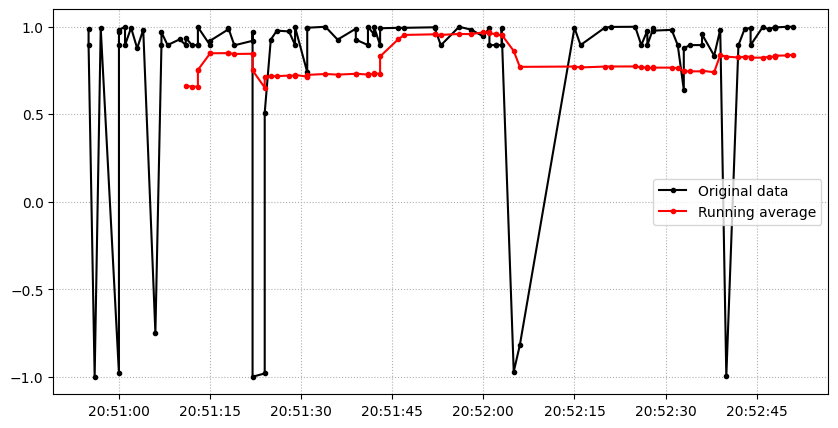

In [21]:
# moving average curve calculation checking 
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(x, y, 'k.-', label='Original data')
plt.plot(x, average_y, 'r.-', label='Running average')
plt.yticks([-1, -0.5, 0, 0.5, 1])
plt.grid(linestyle=':')
plt.legend()
plt.show()

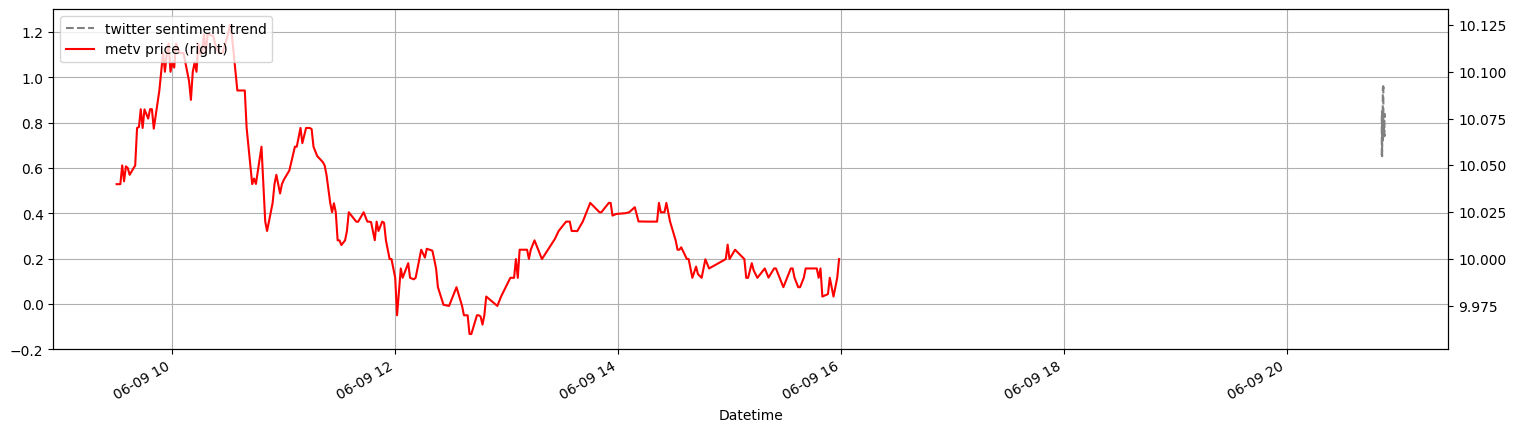

In [22]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(18,5))
plt.xlabel('time')

ax1 = dfxf[name].plot(color='#808080', grid=True, linestyle='dashed',label='twitter sentiment trend')
ax2 = metv["Adj Close"].plot(color='red', grid=True, secondary_y=True, label='metv price')
ax1.set_ylim((-0.2, 1.3))
#ax1.legend(loc=1)
#ax2.legend(loc=2)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()


plt.legend(h1+h2, l1+l2, loc=2)
plt.show()
